### 1.- Importación bibliotecas

In [1]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from importlib import reload
from matplotlib.patches import Rectangle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from datetime import datetime

project_root = Path.cwd().parent  # estando en notebooks/
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import utils.visualizaciones_ext as visx
from importlib import reload
reload(visx)

import utils.visualizaciones_ext as vis
reload(vis)

<module 'utils.visualizaciones_ext' from 'c:\\Users\\Ramón\\Desktop\\comparacion_jugadores_25_26\\utils\\visualizaciones_ext.py'>

### 2.- Paleta de colores

In [2]:
# --------- PALETA "Dark Cyan" (simplificada) ----------
BG_MAIN       = "#0F1420"   # Fondo principal (casi negro azulado)
BG_SECONDARY  = "#1A2233"   # Fondo secundario (cards / paneles)
TEXT_MAIN     = "#E6EDF3"   # Texto principal
TEXT_SECOND   = "#9DA7B3"   # Texto secundario
TITLE_COLOR   = "#F7FAFC"   # Título (más claro para contraste)
ACCENT_CYAN   = "#00E5FF"   # Acento principal (highlights)
ACCENT_WARN   = "#FFD166"   # Acento secundario (avisos/alertas puntuales)
GRID_COLOR    = "#2B3240"   # Bordes / divisores suaves

# Campo (oscuro, no verde)
PITCH_BG      = "#1A1730"   # Fondo del campo (indigo/morado oscuro)
PITCH_LINES   = "#00E5FF"   # Líneas del campo (cian suave)

# --------- Estilo base ----------
plt.rcParams.update({
    "figure.facecolor": BG_MAIN,
    "axes.facecolor": BG_MAIN,
    "savefig.facecolor": BG_MAIN,
    "text.color": TEXT_MAIN,
    "axes.labelcolor": TEXT_MAIN,
    "xtick.color": TEXT_SECOND,
    "ytick.color": TEXT_SECOND,
    "axes.edgecolor": GRID_COLOR,
})

### 3.- Funciones complementarias

In [4]:
# Se usan las funciones de utils7visualizaciones
tidy_axes = vis.tidy_axes  # alias para no tocar el resto del código

def draw_green_pitch(ax, title=None):
    vis.draw_pitch_panel(
        ax,
        title=title,
        pitch_color=PITCH_BG,
        line_color=PITCH_LINES,
        linewidth=0.9,
        title_color=ACCENT_CYAN,
    )

# --- Título (nombre + línea secundaria) ---------------------------------------
def paint_title(ax, text, club=None, pos=None, edad=None, color_name=None):
    # Pinta el nombre centrado y una segunda línea con club/pos/edad
    nombre = text or "Jugador/a"
    linea2 = " · ".join([x for x in [club, pos, (str(edad) if edad is not None else None)] if x])

    ax.text(0.50, 0.90, nombre, va="top", ha="center",
            fontsize=14, fontweight="bold", color=(color_name or TITLE_COLOR))
    if linea2:
        ax.text(0.50, 0.58, linea2, va="top", ha="center",
                fontsize=10, fontweight="semibold", color=TEXT_SECOND)
    tidy_axes(ax, with_frame=False)

# --- Helpers de texto y barras -------------------------------------------------
def _fmt_int(v): 
    # Enteros “limpios” (— si NaN)
    return "—" if pd.isna(v) else f"{int(round(float(v)))}"

def _fmt_pct(v):
    # Porcentajes “0%..100%” (— si NaN)
    return "—" if pd.isna(v) else f"{float(v):.0f}%"

def _bar(ax, x, y, w, W=0.35, h=0.05, color=ACCENT_CYAN, bg=GRID_COLOR):
    # Barra con fondo (bg) y valor (w en 0..1). Anchura lógica W.
    ax.add_patch(Rectangle((x, y), W, h, lw=0, facecolor=bg, alpha=0.25))
    if w is not None:
        ax.add_patch(Rectangle((x, y), max(0, min(1, w))*W, h, lw=0, facecolor=color, alpha=0.9))

def _resolve_pct(pct_field, ok, total):
    """
    Devuelve (w, label) donde:
      - w es 0..1 para la barra
      - label es 0..100 para el texto
    Acepta pct en 79 ó 0.79 y, si falta, calcula ok/total.
    """
    def _to_float(x):
        try:
            return None if pd.isna(x) else float(x)
        except Exception:
            return None

    v = _to_float(pct_field)
    if v is not None:
        if v > 1.0:       # 79 -> 0.79
            return v/100.0, v
        else:             # 0.79 -> 79
            return v, v*100.0

    v_ok, v_tot = _to_float(ok), _to_float(total)
    if v_ok is not None and v_tot not in (None, 0.0):
        w = v_ok / v_tot
        return w, w*100.0

    return None, np.nan

# --- Bloque de métricas en tarjeta (texto + barras) ----------------------------
def paint_basic_stats(ax, p):
    """
    Sin barras:
      - Minutos, Goles, Pases clave, Centros
    Con barras (porcentaje de acierto):
      - Pases: total + comp%     (barra = comp/100)
      - Tiros: total + % a puerta (barra = onTarget/total)
      - Regates: intentos + éxito% (barra = éxito/100)
    """
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    tidy_axes(ax, with_frame=False)

    TX = 0.03   # x del texto
    BX = 0.65   # x de barras
    y  = 0.92   # y inicial
    dy = 0.13  # salto entre líneas

    c = p.get("accent", ACCENT_CYAN)

    # ---- SIN BARRAS -----------------------------------------------------------
    ax.text(TX, y, f"Minutos: { _fmt_int(p.get('minutos')) }", ha="left", va="center", fontsize=10); y -= dy
    ax.text(TX, y, f"Goles: { _fmt_int(p.get('goles')) }",      ha="left", va="center", fontsize=10); y -= dy
    ax.text(TX, y, f"Pases clave: { _fmt_int(p.get('pases_clave')) }", ha="left", va="center", fontsize=10); y -= dy
    ax.text(TX, y, f"Centros: { _fmt_int(p.get('centros')) }",         ha="left", va="center", fontsize=10); y -= dy

    # ---- CON BARRAS -----------------------------------------------------------
    # 1) Pases
    total, ok, pct = p.get("pases_total"), p.get("pases_ok"), p.get("pases_pct")
    w_pass, pct_label = _resolve_pct(pct, ok, total)
    ax.text(TX, y, f"Pases: { _fmt_int(total) } ({ _fmt_pct(pct_label) })",
            ha="left", va="center", fontsize=10)
    _bar(ax, BX, y-0.03, w_pass, color=c); y -= dy

    # 2) Tiros  -> % sobre portería (OT/total). Si quieres puedes dejar “Portería”.
    sh_total, sh_ot = p.get("tiros"), p.get("tiros_OT")
    w_shot, sh_label = _resolve_pct(None, sh_ot, sh_total)  # calcula OT/Total
    ax.text(TX, y, f"Tiros: { _fmt_int(sh_total) } ({ _fmt_pct(sh_label) })",
            ha="left", va="center", fontsize=10)
    _bar(ax, BX, y-0.03, w_shot, color=c); y -= dy

    # 3) Regates
    r_att, r_won, r_pct = p.get("reg_int"), p.get("reg_ok"), p.get("reg_pct")
    w_reg, r_label = _resolve_pct(r_pct, r_won, r_att)
    ax.text(TX, y, f"Regates: { _fmt_int(r_att) } ({ _fmt_pct(r_label) })",
            ha="left", va="center", fontsize=10)
    _bar(ax, BX, y-0.03, w_reg, color=c)

# --- Carga y pintado de imágenes con tamaño uniforme ---------------------------
def _load_rgba(path):
    # Lee imagen y fuerza RGBA (para poder usar alfa)
    im = Image.open(path).convert("RGBA")
    return np.array(im)

def _trim_transparency(arr, thr=1):
    # Recorta márgenes transparentes (si existen) para alinear mejor los iconos
    if arr.shape[-1] < 4:   # sin alfa
        return arr
    alpha = arr[..., 3]
    mask = alpha > thr
    if not mask.any():
        return arr
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1
    return arr[y0:y1, x0:x1, :]

def _place_img_uniform(ax, path, *, height_px=60, pad_px=2, x=0.50, y=0.50):
    # Coloca una imagen centrada con ALTURA física fija (independiente de su resolución)
    try:
        if not path or not isinstance(path, str):
            raise FileNotFoundError
        arr = _load_rgba(path)
        arr = _trim_transparency(arr)
        if pad_px > 0:
            # Añade un pequeño padding transparente para evitar cortes visuales
            h, w, _ = arr.shape
            canvas = np.zeros((h + 2*pad_px, w + 2*pad_px, 4), dtype=arr.dtype)
            canvas[..., 3] = 0
            canvas[pad_px:pad_px+h, pad_px:pad_px+w, :] = arr
            arr = canvas
        zoom = height_px / arr.shape[0]
        oi = OffsetImage(arr, zoom=zoom)
        ab = AnnotationBbox(
            oi, (x, y),
            frameon=False, boxcoords="axes fraction", box_alignment=(0.5, 0.5)
        )
        ax.add_artist(ab)
    except FileNotFoundError:
        # Si falta la imagen no ensuciamos la tarjeta
        pass
    tidy_axes(ax, with_frame=False)

def place_photo(ax, path, *, height_px=100, x=0.40, y=0.56):
    # Foto de jugador (altura estándar). x permite desplazarla horizontalmente.
    _place_img_uniform(ax, path, height_px=height_px, pad_px=0, x=x, y=y)

def place_icon(ax, path, *, height_px=56, x=0.40):
    # Iconos (escudo, bandera) con altura común. x para ajustar alineación.
    _place_img_uniform(ax, path, height_px=height_px, pad_px=2, x=x, y=0.50)

### 4.- Selección métricas

In [5]:
# --- Parámetros base -----------------------------------------------------------
SELECTED_POSITION = "fw"  # No se usa directamente aquí, pero lo dejamos para futuros filtros

# IDs WhoScored en orden (definen el orden vertical de la figura)
PLAYER_IDS = [408449, 480249, 299490]  # Nico, Lamine, Bobb

# Rutas a masters (piezas clave para nombres, equipos, logos, colores)
PATH_MASTER_PLAYERS = "../data/masters/master_jugadores.csv"
PATH_MASTER_TEAMS   = "../data/masters/master_equipos.csv"
PATH_MASTER_MATCHES = "../data/masters/master_partidos.csv"   # (opcional)

# Features de partido (WhoScored) — admite 1..3 CSV (uno por encuentro)
PATH_FEATURES_MATCH = [
    "../data/matches/jornada_1/1J_ATH_SEV_features_jugadores.csv",
    "../data/matches/jornada_1/1J_MLL_FCB_features_jugadores.csv",
]

# Logs “largos” de eventos — para goles/centros (y futuros flags)

PATH_PLAYERS_LOG = [
    "../data/matches/jornada_1/1J_ATH_SEV_lg_jugadores.csv",
    "../data/matches/jornada_1/1J_MLL_FCB_lg_jugadores.csv",
]
PATH_EVENTS_LOG = [
    "../data/matches/jornada_1/1J_ATH_SEV_lg_eventos.csv",
    "../data/matches/jornada_1/1J_MLL_FCB_lg_eventos.csv",
]

MIN_MINUTES = 45  # poner lo deseado para filtrar por tiempo jugado

# --- Lector flexible de CSV (auto ; o ,) --------------------------------------
def _auto_csv(path):
    with open(path, "r", encoding="utf-8") as f:
        first = f.readline()
    sep = ";" if (";" in first and "," not in first) else ","
    df = pd.read_csv(path, sep=sep, encoding="utf-8")
    df.columns = [c.strip() for c in df.columns]
    return df

def _load_many(paths):
    # Concatena varios CSV (para 1..3 partidos por jornada)
    if isinstance(paths, (list, tuple)):
        dfs = [ _auto_csv(p) for p in paths if p ]
        return pd.concat(dfs, ignore_index=True, sort=False) if dfs else pd.DataFrame()
    return _auto_csv(paths)

# Wrappers
def load_master_players(path): return _auto_csv(path)
def load_master_teams(path):   return _auto_csv(path)
def load_features(paths):      return _load_many(paths)
def load_events_log(paths):    return _load_many(paths)

# --- Column helper -------------------------------------------------------------
def _col(df, options):
    # Devuelve la primera columna existente de la lista 'options'
    for c in options:
        if c in df.columns: return c
    return None

# --- Selección de la fila “representativa” de features -------------------------
def _pick_row_for_player(df, pid):
    """
    Devuelve una Series del jugador pid.
    Si hay varias filas (varios partidos), usa la de MÁS MINUTOS si existe 'minutes';
    en caso contrario, la primera.
    """
    if df is None or df.empty: 
        return pd.Series(dtype=object)
    sdf = df[df["playerId"].astype(str) == str(pid)]
    if sdf.empty:
        return pd.Series(dtype=object)
    if "minutes" in sdf.columns:
        idx = sdf["minutes"].fillna(0).astype(float).idxmax()
        try:    return sdf.loc[idx]
        except: return sdf.iloc[0]
    return sdf.iloc[0]

# --- True/False/1/0 → 0/1 -----------------------------------------------------
def _truthy_to_int(series):
    # Normaliza banderas con diferentes formatos (True/False, 1/0, "true"...)
    def _t(x):
        if pd.isna(x): return 0
        if isinstance(x, (int, float)): return int(x > 0)
        s = str(x).strip().lower()
        return 1 if s in {"1","true","t","yes","y","si","sí"} else 0
    return series.map(_t)

def _sum_if_col(df, colname):
    # Suma la columna si existe (interpretada como 0/1); si no existe, devuelve 0
    return int(_truthy_to_int(df[colname]).sum()) if colname in df.columns else 0

# ---- Helpers para contar eventos del log ----
# --- Normalizador de 'type' y contadores robustos ---
def _norm_type_series(s):
    # pasa a str, baja a minúsculas y quita espacios/guiones/underscores
    return s.astype(str).str.lower().str.replace(r"[\s_\-]+", "", regex=True)

def _count_types_norm(df, tokens):
    """Cuenta filas cuyo type (normalizado) está en 'tokens' ya normalizados."""
    if df is None or df.empty or "type" not in df.columns:
        return 0
    norm = _norm_type_series(df["type"])
    return int(norm.isin(set(tokens)).sum())

def _sum_flags(df, flags):
    """Suma columnas-flag (0/1, True/False, '1.00', etc.) robustamente."""
    if df is None or df.empty:
        return 0
    tot = 0
    for col in flags:
        if col in df.columns:
            tot += _truthy_to_int(df[col]).sum()
    return int(tot)

def _canon_pid_series(s):
    # 408449.00 -> "408449" ; "408449" -> "408449"
    return (pd.to_numeric(s, errors="coerce")
            .astype("Int64")          # Int “nullable”
            .astype(str))             # a string limpia

# --- Construcción del perfil de cada jugador ----------------------------------
def build_profiles(player_ids, selected_position):
    # 1) Carga datos
    m  = load_master_players(PATH_MASTER_PLAYERS)
    t  = load_master_teams(PATH_MASTER_TEAMS)
    f  = load_features(PATH_FEATURES_MATCH)
    ev = load_events_log(PATH_EVENTS_LOG)

    # 2) Detecta columnas clave en masters
    col_id     = _col(m, ["playerID","playerId","player_id","id"])
    col_name   = _col(m, ["name","nick_name","name_ws","nameWS"])
    col_team   = _col(m, ["team","nombre_equipo","Squad","Equipo"])
    col_teamac = _col(m, ["nick_team","acronimo","team_acronym"])
    col_pos    = _col(m, ["position","nick_position","pos","Pos"])
    col_nat    = _col(m, ["nacionalidad","Nation","Nacionalidad"])
    col_foto   = _col(m, ["foto_local","foto_path","foto","image_path"])
    col_logo   = _col(m, ["logo_local","logo_path"])
    col_flag   = _col(m, ["flag_local","flag_path"])
    if col_id is None:
        raise ValueError(f"No encuentro columna de ID en master_jugadores. Tengo: {list(m.columns)}")

    col_t_acr  = _col(t, ["acronimo","nick_team","team_code"])
    col_t_logo = _col(t, ["logo_local","logo_path"])
    col_t_hex  = _col(t, ["color_primario","primary_color"])

    # 3) Ordena 'sel' siguiendo PLAYER_IDS
    ids_series = m[col_id].astype(str)
    wanted     = list(map(str, player_ids))
    sel = m[ids_series.isin(wanted)].copy()
    sel["__order"] = pd.Categorical(ids_series[sel.index], categories=wanted, ordered=True)
    sel = sel.sort_values("__order").drop(columns="__order")

    if not f.empty:
        f["playerId"] = _canon_pid_series(f["playerId"])
        f_ok = f[f.get("minutes", 0).fillna(0) >= MIN_MINUTES].copy() if "minutes" in f.columns else f.copy()
    else:
        f_ok = pd.DataFrame(columns=["playerId"])

    if not ev.empty:
        ev["playerId"] = _canon_pid_series(ev["playerId"])
    else:
        ev = pd.DataFrame(columns=["playerId"])

    # 5) Lookup de equipo → logo y color
    team_lookup = (t[[col_t_acr, col_t_logo, col_t_hex]].rename(
        columns={col_t_acr:"acr", col_t_logo:"team_logo_local", col_t_hex:"team_color_hex"}
    ) if col_t_acr else pd.DataFrame(columns=["acr","team_logo_local","team_color_hex"]))

    profiles = []
    for _, r in sel.iterrows():
        pid = str(r[col_id])

        # 6) Fila de features (la de más minutos)
        rf = _pick_row_for_player(f_ok, pid) if not f_ok.empty else pd.Series(dtype=object)

        # 7) Subconjunto de eventos del jugador (concatenado de 1..3 partidos)
        evp = ev[ev["playerId"] == pid] if not ev.empty else pd.DataFrame(columns=["playerId"])

        # 8) Métricas desde eventos (robustas a columnas ausentes + types inconsistentes)
        # --- normaliza 'type' una sola vez
        norm_type = _norm_type_series(evp["type"]) if ("type" in evp.columns and not evp.empty) else pd.Series(dtype=object)

        # Goles (SIN duplicar): OR entre flag isGoal y type == 'goal'
        if not evp.empty:
            goal_flag = _truthy_to_int(evp["isGoal"]) if "isGoal" in evp.columns else pd.Series([0]*len(evp))
            goal_type = norm_type.isin({"goal"})      if "type"   in evp.columns else pd.Series([False]*len(evp))
            goles = int((goal_flag.gt(0) | goal_type).sum())
        else:
            goles = 0

        # Tiros:
        # - Total = savedshot + missedshots + shotonpost + goal
        # - A puerta = savedshot + goal + shotonpost  (incluimos 'al palo')
        SHOT_ANY = {"savedshot","missedshots","shotonpost","goal"}
        SHOT_OT  = {"savedshot","goal","shotonpost"}   # 'al palo' cuenta como OT

        shots_total = int(norm_type.isin(SHOT_ANY).sum()) if "type" in evp.columns else 0
        shots_on_t  = int(norm_type.isin(SHOT_OT).sum())  if "type" in evp.columns else 0

        # Centros (intentos): cross + blockedcross
        centros = _sum_flags(evp, ["qNone_Cross", "qNone_BlockedCross"])

        # Pases clave (eventos)
        kp_events = _sum_flags(evp, ["qNone_KeyPass", "qNone_ShotAssist"])

        # Asistencias
        asist = _sum_flags(evp, ["qNone_Assisted", "qNone_IntentionalAssist", "qNone_IntentionalGoalAssist"])

        # Big chances (opcionales)
        bc_created = _sum_flags(evp, ["qNone_BigChanceCreated"])
        bc_shooter = _sum_flags(evp, ["qNone_BigChance"])

        # 9) Logo/colores desde equipos
        acr = r.get(col_teamac)
        rt = (team_lookup[team_lookup["acr"] == acr].iloc[0]
              if (acr is not None and not team_lookup.empty and acr in set(team_lookup["acr"]))
              else pd.Series(dtype=object))

        foto = r.get(col_foto)
        logo = r.get(col_logo) or rt.get("team_logo_local")
        flag = r.get(col_flag)

        edad_val = rf.get("age")
        edad_val = int(edad_val) if pd.notna(edad_val) else None

        # 10) Construye el perfil
        p = {
            "playerId":   pid,
            "nombre":     r.get(col_name),
            "edad":       edad_val,
            "club":       r.get(col_team),
            "pos":        r.get(col_pos),
            "nac":        r.get(col_nat),

            "foto":       (f"../{foto}" if isinstance(foto, str) else None),
            "logo":       (f"../{logo}" if isinstance(logo, str) else None),
            "flag":       (f"../{flag}" if isinstance(flag, str) else None),

            # Colores por equipo
            "accent":     (rt.get("team_color_hex") if isinstance(rt.get("team_color_hex"), str) else ACCENT_CYAN),
            "name_color": (rt.get("team_color_hex") if isinstance(rt.get("team_color_hex"), str) else TITLE_COLOR),

            # Features (con fallback a eventos cuando falten)
            "minutos":     rf.get("minutes"),
            "pases_total": rf.get("s_passesTotal"),
            "pases_ok":    rf.get("s_passesAccurate"),
            "pases_pct":   rf.get("s_passSuccess"),

            "tiros":       (rf.get("s_shotsTotal")    if pd.notna(rf.get("s_shotsTotal"))    else shots_total),
            "tiros_OT":    (rf.get("s_shotsOnTarget") if pd.notna(rf.get("s_shotsOnTarget")) else shots_on_t),

            "reg_int":     rf.get("s_dribblesAttempted"),
            "reg_ok":      rf.get("s_dribblesWon"),
            "reg_pct":     rf.get("s_dribbleSuccess"),

            # Eventos / compuestos (los usa tu bloque sin barras)
            "goles":         int(goles),
            "asist":         int(asist),
            "pases_clave":   (rf.get("s_passesKey") if pd.notna(rf.get("s_passesKey")) else kp_events),
            "centros":       int(centros),

            # (opcionales si quieres mostrarlos más tarde)
            # "bc_created":  int(bc_created),
            # "bc_shooter":  int(bc_shooter),
        }
        profiles.append(p)

    return profiles

# Construye profiles (usa features + lg_eventos)
profiles = build_profiles(PLAYER_IDS, SELECTED_POSITION)

### 5.- Función de despliegue

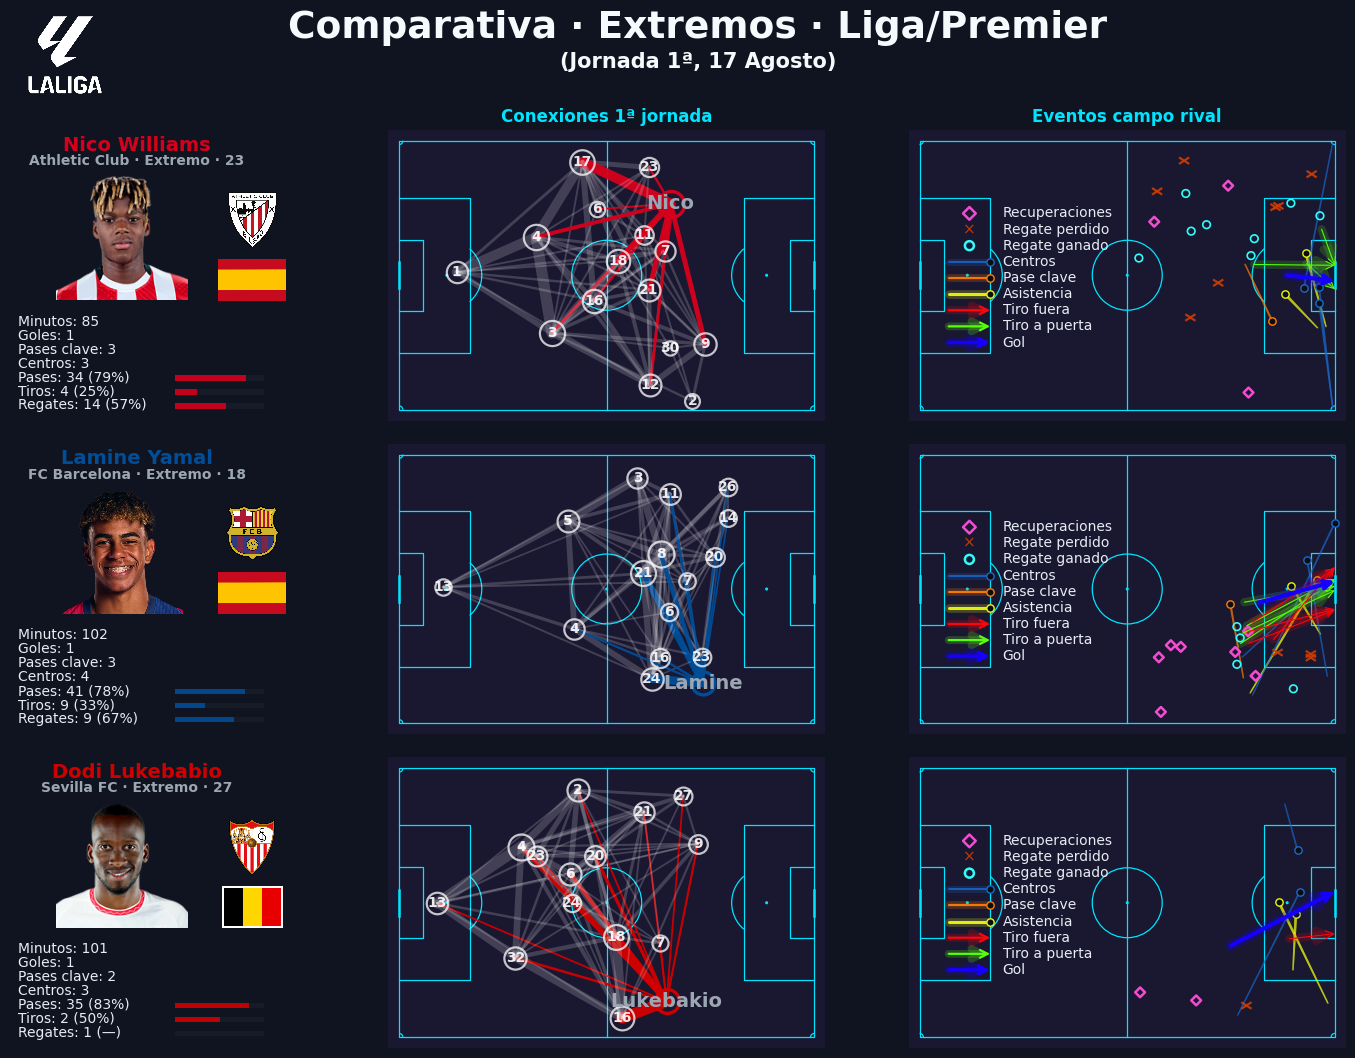

In [6]:
# --------- FIGURA & GRID ------------------------------------------------------
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(
    3, 3,
    width_ratios=[1.00, 2.35, 2.35],   # col0 (tarjeta) algo más ancha
    wspace=0.008,                      # espacio entre columnas
    hspace=0.08                        # espacio entre filas
)

# --- Columna 0: título + (foto | escudo/flag) + stats -------------------------
ax_name, ax_photo, ax_logo, ax_flag, ax_stats = [], [], [], [], []
for r in range(3):
    # Subgrid vertical de la tarjeta
    gcol0 = gs[r, 0].subgridspec(3, 1, height_ratios=[0.20, 0.42, 0.38], hspace=0.04)

    # 0a) título
    ax_name.append(fig.add_subplot(gcol0[0, 0]));   tidy_axes(ax_name[-1], with_frame=False)

    # 0b) fila imágenes: [foto | (escudo/flag apilados)]
    gimgs   = gcol0[1, 0].subgridspec(1, 2, width_ratios=[0.92, 0.08], wspace=0.006)
    ax_photo.append(fig.add_subplot(gimgs[0, 0]))
    gbadges = gimgs[0, 1].subgridspec(2, 1, height_ratios=[0.45, 0.45], hspace=0.015)
    ax_logo.append(fig.add_subplot(gbadges[0, 0]))
    ax_flag.append(fig.add_subplot(gbadges[1, 0]))
    tidy_axes(ax_photo[-1], False); tidy_axes(ax_logo[-1], False); tidy_axes(ax_flag[-1], False)

    # 0c) stats (texto+barras)
    ax_stats.append(fig.add_subplot(gcol0[2, 0]));  tidy_axes(ax_stats[-1], with_frame=False)

# --- Columnas 1 y 2: placeholders de cancha (para futuras visualizaciones) ----
# Columna 1, Red de pases destacada de cada jugador

ax_red = [fig.add_subplot(gs[r, 1]) for r in range(3)]
for i, ax in enumerate(ax_red):
    draw_green_pitch(ax, title="Conexiones 1ª jornada" if i == 0 else None)

# Fila 0: Nico
vis.plot_pass_network_for_player_auto(
    ax=ax_red[0],
    player_id=PLAYER_IDS[0],             # 408449
    players_files=PATH_PLAYERS_LOG,
    events_files=PATH_EVENTS_LOG,
    master_teams_path=PATH_MASTER_TEAMS, # para resolver color si no lo pasas
    team_color=profiles[0]["accent"],    # usa tu color de equipo
    show_all=True,
    highlight_label="Nico",              # ← NICK explícito
    highlight_text_color="#9DA7B3"       # ← adecuar color
)

# Fila 1: Lamine
vis.plot_pass_network_for_player_auto(
    ax=ax_red[1],
    player_id=PLAYER_IDS[1],             # 480249
    players_files=PATH_PLAYERS_LOG,
    events_files=PATH_EVENTS_LOG,
    master_teams_path=PATH_MASTER_TEAMS,
    team_color=profiles[1]["accent"],
    show_all=True,
    highlight_label="Lamine",              # ← NICK explícito
    highlight_text_color="#9DA7B3"       # ← adecuar color
)

# Fila 2: Lukebakio
vis.plot_pass_network_for_player_auto(
    ax=ax_red[2],
    player_id=PLAYER_IDS[2],             # 299490
    players_files=PATH_PLAYERS_LOG,
    events_files=PATH_EVENTS_LOG,
    master_teams_path=PATH_MASTER_TEAMS,
    team_color=profiles[2]["accent"],
    show_all=True,
    highlight_label="Lukebakio",              # ← NICK explícito
    highlight_text_color="#9DA7B3"       # ← adecuar color
)

# --- Columna 2: Acciones típicas por jugador (mitad derecha de cada fila)
ax_accion = [fig.add_subplot(gs[r, 2]) for r in range(3)]
for i, ax in enumerate(ax_accion):
    # Dibuja el campo con tu estilo
    draw_green_pitch(ax, title="Eventos campo rival" if i == 0 else None)

    # Pinta acciones del jugador i (leyenda incluida en cada panel)
    visx.plot_winger_actions_for_player_auto(
        ax=ax,
        player_id=profiles[i]["playerId"],      # usa los mismos perfiles cargados
        players_files=PATH_PLAYERS_LOG,
        events_files=PATH_EVENTS_LOG,
        show_legend=True
    )

# --- Cabecera (títulos + logos de competiciones) ------------------------------
main_title = "Comparativa · Extremos · Liga/Premier"
sub_title  = "(Jornada 1ª, 17 Agosto)"

plt.subplots_adjust(top=0.875, left=0.07, right=0.98)
fig.suptitle(main_title, fontsize=27, fontweight="bold", color=TITLE_COLOR, y=0.975, ha="center")
fig.text(0.5, 0.94, sub_title, ha="center", va="top", fontsize=15, fontweight="semibold", color=TITLE_COLOR)


# === Compactar columnas 1 y 2 (¡después del subplots_adjust y títulos!) ===
fig.canvas.draw()  # asegura posiciones “definitivas” antes de leer bounds

GAP = 0.002  # separación deseada entre ambas columnas
for r in range(3):
    axA = ax_red[r]
    axB = ax_accion[r]

    xa, ya, wa, ha = axA.get_position().bounds
    xb, yb, wb, hb = axB.get_position().bounds

    right = xb + wb                    # borde derecho actual de la col 2
    new_w = (right - xa - GAP) / 2.0   # mismo ancho para ambas

    axA.set_position([xa,              ya, new_w, ha])           # red de pases
    axB.set_position([xa + new_w + GAP, yb, new_w, hb])          # eventos


# Logos de competiciones (posición absoluta en la figura)
logo_ax  = fig.add_axes([0.082, 0.905, 0.055, 0.065]);  place_icon(logo_ax,  "../images/logos/laliga.png")
# Descomentar la siguiente cuando se midan algunos jugadores de otras competiciones
# logo_ax2 = fig.add_axes([0.85, 0.905, 0.035, 0.035]);  place_icon(logo_ax2, "../images/logos/Whoscored.png")

# --- Pintado de cada tarjeta ---------------------------------------------------
for i, p in enumerate(profiles):
    # Título coloreado con color del equipo
    paint_title(ax_name[i], p.get("nombre"), club=p.get("club"), pos=p.get("pos"),
                edad=p.get("edad"), color_name=p.get("name_color"))

    # Imágenes con altura uniforme
    place_photo(ax_photo[i], p.get("foto"),  height_px=90, x=0.48, y=0.60)  # foto algo a la izquierda
    place_icon (ax_logo[i],  p.get("logo"),  height_px=40, x=0.40)
    place_icon (ax_flag[i],  p.get("flag"),  height_px=30, x=0.40)

    # Bloque de métricas
    paint_basic_stats(ax_stats[i], p)

# Guardar figura si queremos

SAVE_FIG = False  # cambiar a True cuando quiera exportarse

# Ruta de salida (elegir una):
# 1) Carpeta relativa al proyecto:
EXPORT_DIR = (Path.cwd().parent / "outputs"/"dashboards"/"jornada_1").resolve()

# 2) O ruta absoluta en Windows (ejemplo):
# EXPORT_DIR = Path(r"C:\Users\TuUsuario\Desktop\salidas")

FILENAME = f"Comparativa_extremos_j1_h.png"
OUT_PATH = EXPORT_DIR / FILENAME

if SAVE_FIG:
    EXPORT_DIR.mkdir(parents=True, exist_ok=True)
    # Usar el color REAL de la figura aunque no tenga a mano BG_COLOR
    fig.savefig(
        OUT_PATH,
        dpi=300,
        facecolor=fig.get_facecolor(),  # ← así no necesitas pasar BG_COLOR
        bbox_inches="tight",
        pad_inches=0.2
    )
    print(f"Guardado en: {OUT_PATH}")    

plt.show()